In [ ]:
# This model will be used for every month report to show who is likely to abandend their store. 


In [91]:

%pip install scikit-learn

In [232]:
%pip install imbalanced-learn

In [118]:
%pip install xgboost

   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---- ----------------------------------- 7.1/56.8 MB 33.6 MB/s eta 0:00:02
   ---------- ----------------------------- 15.5/56.8 MB 37.4 MB/s eta 0:00:02
   --------------- ------------------------ 22.5/56.8 MB 36.6 MB/s eta 0:00:01
   --------------------- ------------------ 29.9/56.8 MB 36.5 MB/s eta 0:00:01
   -------------------------- ------------- 37.2/56.8 MB 36.4 MB/s eta 0:00:01
   ------------------------------ --------- 43.5/56.8 MB 35.5 MB/s eta 0:00:01
   ----------------------------------- ---- 50.6/56.8 MB 35.4 MB/s eta 0:00:01
   ---------------------------------------  56.6/56.8 MB 35.4 MB/s eta 0:00:01
   ---------------------------------------  56.6/56.8 MB 35.4 MB/s eta 0:00:01
   ---------------------------------------- 56.8/56.8 MB 30.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [711]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score,cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.metrics import accuracy_score,mean_squared_error,mean_absolute_error,r2_score,classification_report,precision_recall_curve
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
import joblib
import os

In [ ]:
#get the data ready

In [712]:
pay=pd.read_csv(r"C:\Users\silve\Desktop\Data Science\Projects\Trade Franchises\Meta Data\Raw data\Payments.csv")
pay["total"]=pay["Missed_Payments_12mo"]+pay["Missed_Payments_6mo"]+pay["Missed_Payments_3mo"]
pay.head(1)

,Store_ID,Missed_Payments_12mo,Missed_Payments_6mo,Missed_Payments_3mo,Initial_Fee_Paid,Initial_Fee_Remaining,Initial_Fee_On_Schedule,Royalty_Paid_Expected,Royalty_Paid_Actual,Marketing_Paid_Expected,Marketing_Paid_Actual,Min_Royalty_Biweekly,Missed_Marketing_Payment_Streak,total
0,STORE_0,2,1,1,29850,10000,Yes,19046,750,900,6000,750,2,4


In [714]:
outcome=pd.read_csv(r"C:\Users\silve\Desktop\Data Science\Projects\Trade Franchises\Meta Data\Raw data\Outcome.csv")
outcome.head(1)

,Store_ID,Abandoned
0,STORE_0,0


In [715]:
leg=pd.read_csv(r"C:\Users\silve\Desktop\Data Science\Projects\Trade Franchises\Meta Data\Raw data\Legal_Audit.csv")
leg.head(1)

,Store_ID,Legal_Notice_Sent,Court_Action_Filed,Audit_Score,Customer_Complaint_Flag,Red_Flag_Count
0,STORE_0,No,No,61,No,1


In [716]:
store=pd.read_csv(r"C:\Users\silve\Desktop\Data Science\Projects\Trade Franchises\Meta Data\Raw data\Stores.csv")
store.head(1)

,Store_ID,Brand,State,Zipcode,Store_Years_Open,Owner_ID
0,STORE_0,Benjamin Franklin,NY,29767,4,OWN_161


In [717]:
outcome["Legal_Notice_Sent"]=leg["Legal_Notice_Sent"]
outcome.head(1)

,Store_ID,Abandoned,Legal_Notice_Sent
0,STORE_0,0,No


In [ ]:
# will create an outcome(y) for our model. by combning legal notice sent from leg, total(missed payments) from pay

In [719]:
outcome["total"]=pay["total"]
outcome["Sotre_Years_Open"]=store["Store_Years_Open"]


In [720]:
outcome1=outcome[(outcome["Legal_Notice_Sent"]=="Yes") & (outcome["total"]>3)& (outcome["Sotre_Years_Open"]<9)]
outcome1

,Store_ID,Abandoned,Legal_Notice_Sent,total,Sotre_Years_Open
2,STORE_2,1,Yes,4,4
39,STORE_39,1,Yes,6,2
64,STORE_64,0,Yes,4,7
77,STORE_77,0,Yes,4,7
208,STORE_208,0,Yes,6,8
280,STORE_280,0,Yes,7,7
309,STORE_309,0,Yes,5,5
325,STORE_325,0,Yes,4,7
383,STORE_383,0,Yes,5,6
389,STORE_389,1,Yes,4,2


In [ ]:
# Creating the (X) the trianing data 

In [721]:
fran_abano=store
fran_abano=pd.concat([fran_abano,pay],axis=1)
fran_abano.drop(columns="Store_ID",inplace=True)
fran_abano.head(1)

,Brand,State,Zipcode,Store_Years_Open,Owner_ID,Missed_Payments_12mo,Missed_Payments_6mo,Missed_Payments_3mo,Initial_Fee_Paid,Initial_Fee_Remaining,Initial_Fee_On_Schedule,Royalty_Paid_Expected,Royalty_Paid_Actual,Marketing_Paid_Expected,Marketing_Paid_Actual,Min_Royalty_Biweekly,Missed_Marketing_Payment_Streak,total
0,Benjamin Franklin,NY,29767,4,OWN_161,2,1,1,29850,10000,Yes,19046,750,900,6000,750,2,4


In [722]:
fran_abano["Store_ID"]=store["Store_ID"]

In [723]:
fran_abano["Legal_Notice_Sent"]=outcome["Legal_Notice_Sent"]
fran_abano["outcome"]=0
fran_abano.head(1)

,Brand,State,Zipcode,Store_Years_Open,Owner_ID,Missed_Payments_12mo,Missed_Payments_6mo,Missed_Payments_3mo,Initial_Fee_Paid,Initial_Fee_Remaining,...,Royalty_Paid_Expected,Royalty_Paid_Actual,Marketing_Paid_Expected,Marketing_Paid_Actual,Min_Royalty_Biweekly,Missed_Marketing_Payment_Streak,total,Store_ID,Legal_Notice_Sent,outcome
0,Benjamin Franklin,NY,29767,4,OWN_161,2,1,1,29850,10000,...,19046,750,900,6000,750,2,4,STORE_0,No,0


In [ ]:
# assigning the outcome to the correct store number

In [724]:

for n in range(len(fran_abano["Store_ID"])):
    temp=fran_abano.iloc[n,18]
    m=0 
    while m<=13:
        if temp==outcome1.iloc[m,0]:
            fran_abano.iloc[n,20]=1
            m=20
        else:
            m=m+1
        

In [725]:
fran_abano.head(1)

,Brand,State,Zipcode,Store_Years_Open,Owner_ID,Missed_Payments_12mo,Missed_Payments_6mo,Missed_Payments_3mo,Initial_Fee_Paid,Initial_Fee_Remaining,...,Royalty_Paid_Expected,Royalty_Paid_Actual,Marketing_Paid_Expected,Marketing_Paid_Actual,Min_Royalty_Biweekly,Missed_Marketing_Payment_Streak,total,Store_ID,Legal_Notice_Sent,outcome
0,Benjamin Franklin,NY,29767,4,OWN_161,2,1,1,29850,10000,...,19046,750,900,6000,750,2,4,STORE_0,No,0


In [726]:
Y=fran_abano["outcome"]  # assigning y 

In [727]:
X=fran_abano
X.head(1)

,Brand,State,Zipcode,Store_Years_Open,Owner_ID,Missed_Payments_12mo,Missed_Payments_6mo,Missed_Payments_3mo,Initial_Fee_Paid,Initial_Fee_Remaining,...,Royalty_Paid_Expected,Royalty_Paid_Actual,Marketing_Paid_Expected,Marketing_Paid_Actual,Min_Royalty_Biweekly,Missed_Marketing_Payment_Streak,total,Store_ID,Legal_Notice_Sent,outcome
0,Benjamin Franklin,NY,29767,4,OWN_161,2,1,1,29850,10000,...,19046,750,900,6000,750,2,4,STORE_0,No,0


In [ ]:
#need to drop few items that are not needed for the model. 

In [728]:
X.drop(columns=["Store_ID","Owner_ID","outcome","Legal_Notice_Sent","Zipcode"],inplace=True,axis=1)
X["total"]=pay["total"]
X.head(1)

,Brand,State,Store_Years_Open,Missed_Payments_12mo,Missed_Payments_6mo,Missed_Payments_3mo,Initial_Fee_Paid,Initial_Fee_Remaining,Initial_Fee_On_Schedule,Royalty_Paid_Expected,Royalty_Paid_Actual,Marketing_Paid_Expected,Marketing_Paid_Actual,Min_Royalty_Biweekly,Missed_Marketing_Payment_Streak,total
0,Benjamin Franklin,NY,4,2,1,1,29850,10000,Yes,19046,750,900,6000,750,2,4


In [464]:

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 16 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Brand                            600 non-null    object
 1   State                            600 non-null    object
 2   Store_Years_Open                 600 non-null    int64 
 3   Missed_Payments_12mo             600 non-null    int64 
 4   Missed_Payments_6mo              600 non-null    int64 
 5   Missed_Payments_3mo              600 non-null    int64 
 6   Initial_Fee_Paid                 600 non-null    int64 
 7   Initial_Fee_Remaining            600 non-null    int64 
 8   Initial_Fee_On_Schedule          600 non-null    object
 9   Royalty_Paid_Expected            600 non-null    int64 
 10  Royalty_Paid_Actual              600 non-null    int64 
 11  Marketing_Paid_Expected          600 non-null    int64 
 12  Marketing_Paid_Actual            600

In [ ]:
# preprocessing steps for numbers 

In [729]:
numberx=X.select_dtypes(include=['int64']).columns.tolist()


In [730]:
scaler=StandardScaler()
scaled_feat=scaler.fit_transform(X[numberx])

In [731]:
scaledx=pd.DataFrame(scaled_feat,columns=scaler.get_feature_names_out(numberx))

In [733]:
numberdx=pd.concat([X.drop(columns=numberx),scaledx],axis=1)
X=numberdx
X.head(1)

,Brand,State,Initial_Fee_On_Schedule,Store_Years_Open,Missed_Payments_12mo,Missed_Payments_6mo,Missed_Payments_3mo,Initial_Fee_Paid,Initial_Fee_Remaining,Royalty_Paid_Expected,Royalty_Paid_Actual,Marketing_Paid_Expected,Marketing_Paid_Actual,Min_Royalty_Biweekly,Missed_Marketing_Payment_Streak,total
0,Benjamin Franklin,NY,Yes,-0.644196,0.382118,0.042751,0.686563,-1.180415,0.420745,1.446818,-0.943470,-1.577278,0.626816,0.0,0.022425,0.592159
1,Benjamin Franklin,MD,Yes,1.608239,-0.400376,2.094782,-0.695779,-0.115459,-0.701241,1.438350,0.294576,-0.407312,1.555431,0.0,-1.393915,0.592159
2,One Hour,CA,Yes,-0.644196,1.164611,-0.983265,0.686563,0.303937,2.664715,-1.728826,2.416941,0.239987,-0.920877,0.0,-0.685745,0.592159
3,Benjamin Franklin,CA,Yes,-0.644196,1.947104,0.042751,-0.695779,-1.460629,-0.701241,-1.356041,-0.884515,-0.774728,1.555431,0.0,-0.685745,1.168937
4,One Hour,MD,Yes,-0.869440,-0.400376,-0.983265,2.068905,-1.142771,-0.701241,-1.523291,-0.884515,-1.124853,-1.075646,0.0,-1.393915,0.015381


In [ ]:
# onehotencoding for catagries 

In [734]:
catx=X.select_dtypes(include=["object"]).columns.tolist()

In [735]:
encoder=OneHotEncoder(sparse_output=False)
encode_feat=encoder.fit_transform(X[catx])

In [736]:
encodedcat=pd.DataFrame(encode_feat,columns=encoder.get_feature_names_out(catx))


In [737]:
prep=pd.concat([X.drop(columns=catx),encodedcat],axis=1)
X=prep
X.head()

,Store_Years_Open,Missed_Payments_12mo,Missed_Payments_6mo,Missed_Payments_3mo,Initial_Fee_Paid,Initial_Fee_Remaining,Royalty_Paid_Expected,Royalty_Paid_Actual,Marketing_Paid_Expected,Marketing_Paid_Actual,...,State_GA,State_MD,State_NC,State_NY,State_SC,State_TX,State_VA,State_WA,Initial_Fee_On_Schedule_No,Initial_Fee_On_Schedule_Yes
0,-0.644196,0.382118,0.042751,0.686563,-1.180415,0.420745,1.446818,-0.943470,-1.577278,0.626816,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.608239,-0.400376,2.094782,-0.695779,-0.115459,-0.701241,1.438350,0.294576,-0.407312,1.555431,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.644196,1.164611,-0.983265,0.686563,0.303937,2.664715,-1.728826,2.416941,0.239987,-0.920877,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.644196,1.947104,0.042751,-0.695779,-1.460629,-0.701241,-1.356041,-0.884515,-0.774728,1.555431,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.869440,-0.400376,-0.983265,2.068905,-1.142771,-0.701241,-1.523291,-0.884515,-1.124853,-1.075646,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
# saving X as csv file for reference  

In [704]:
X.to_csv(r"C:\Users\silve\Desktop\Data Science\Projects\Trade Franchises\Meta Data\Raw data\readyx.csv")

In [ ]:
# logistic Regression 

In [738]:
#the stratify=y parameter tells train_test_split to split the data so that the proportion of each class in y is the same in both the training and test sets.
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2, random_state=42, stratify=Y)

In [739]:
l=LogisticRegression(class_weight="balanced")

In [740]:
l.fit(x_train,y_train)

LogisticRegression(class_weight='balanced')

In [741]:
predict=l.predict(x_test)

In [742]:
print(f"Accuracy rate: {np.round(100*accuracy_score(y_test,predict))}%")

Accuracy rate: 86.0%


In [743]:
print(classification_report(y_test,predict))

              precision    recall  f1-score   support

           0       0.98      0.87      0.92       117
           1       0.06      0.33      0.11         3

    accuracy                           0.86       120
   macro avg       0.52      0.60      0.51       120
weighted avg       0.96      0.86      0.90       120



In [ ]:
# the recall for the model is very bad. 

# Smote - need to make the data balanced. we only have 3 need to make the numbers even for training 

In [744]:
smote=SMOTE(random_state=42)
x_res,y_res=smote.fit_resample(x_train,y_train)

In [745]:
y_res.value_counts()
# outcome 1 goes from 11 to 469 using syntatic samples to balance the dataset 

outcome
0    469
1    469
Name: count, dtype: int64

In [746]:
l1=LogisticRegression(class_weight='balanced',random_state=42)
l1.fit(x_res,y_res)

LogisticRegression(class_weight='balanced', random_state=42)

In [747]:
y_prob=l1.predict_proba(x_test)[:,1]

In [748]:
minority_indices = np.where(y_test == 1)[0]
print("\nTest set minority sample indices:", minority_indices)

# Their predicted probabilities
for idx in minority_indices:
    print(f"Index {idx}, True: {y_test.iloc[idx]}, Prob: {y_prob[idx]:.4f}, Pred: {y_pred[idx]}")


Test set minority sample indices: [ 44  53 103]
Index 44, True: 1, Prob: 0.7064, Pred: 0
Index 53, True: 1, Prob: 0.0048, Pred: 0
Index 103, True: 1, Prob: 0.0215, Pred: 0


In [749]:
thr=0.7
y_pred=(y_prob>=thr).astype(int)

In [750]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.91      0.95       117
           1       0.09      0.33      0.14         3

    accuracy                           0.90       120
   macro avg       0.54      0.62      0.54       120
weighted avg       0.96      0.90      0.93       120



In [ ]:
#  use cross validation to test the model for more than 3 samples. 

In [ ]:
# also use pipeline to make the process smooth 

In [751]:
skf=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [752]:
y_true_all=[]
y_predict_all=[]

for train_idx,test_idx in skf.split(X,Y):
    x_train,x_test=X.iloc[train_idx],X.iloc[test_idx]
    y_train,y_test=Y.iloc[train_idx],Y.iloc[test_idx]
    pipeline=Pipeline([('smote',smote),('classifier',l1)])
    pipeline.fit(x_train,y_train)
    predict=pipeline.predict(x_test)

    y_true_all.extend(y_test)
    y_predict_all.extend(predict)

print(classification_report(y_true_all,y_predict_all))

              precision    recall  f1-score   support

           0       0.98      0.86      0.92       586
           1       0.05      0.29      0.08        14

    accuracy                           0.84       600
   macro avg       0.51      0.57      0.50       600
weighted avg       0.96      0.84      0.90       600



# feature_important 

In [ ]:
# to see what columns(features) are important

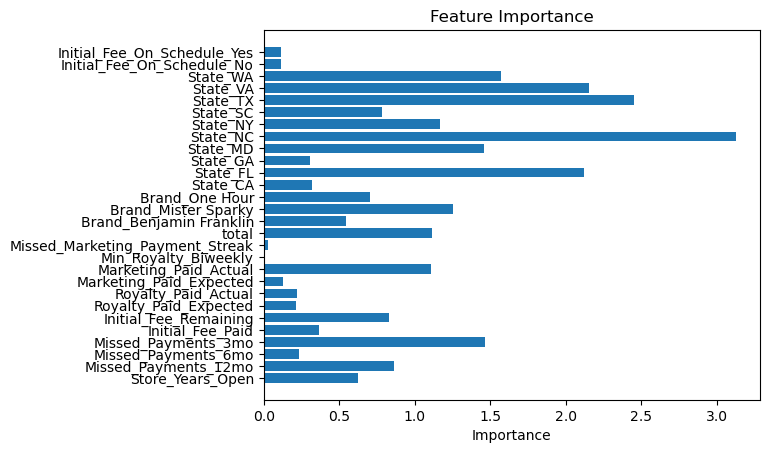

In [756]:
feature_important=np.mean(np.abs(l1.coef_),axis=0)
plt.barh(X.columns,feature_important)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.show()

In [757]:
for n in range(len(X.columns)):
    temp=X.columns[n]
    temp2=feature_important[n]
    temp3=pd.DataFrame([{temp:temp2}])
    important[n]=temp3



more1=important[important.iloc[0:]>1]
more1=more1.dropna(axis=1)
more1

,3,9,12,14,17,19,20,21,23,24,25
0,1.467188,1.109254,1.117564,1.25083,2.11835,1.458822,3.128855,1.167091,2.451454,2.151625,1.574059


# lets try XGBoost - main objective is t get the recall for class 1 as high as possible- we do not want to miss any store that
# might be abondend. 


In [758]:
y_real=[]
y_pre2=[]

for train_id,test_id in skf.split(X,Y):
    x_train,x_test=X.iloc[train_id],X.iloc[test_id]
    y_train,y_test=Y.iloc[train_id],Y.iloc[test_id]

    xgb1=XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight= (len(y_train)-sum(y_train))/sum(y_train)
    )

    pipeline1=Pipeline([('smote',smote),('classifier',xgb1)])
    
    pipeline1.fit(x_train,y_train)
    pred=pipeline1.predict(x_test)

    y_real.extend(y_test)
    y_pre2.extend(pred)


print(classification_report(y_real,y_pre2))


              precision    recall  f1-score   support

           0       0.98      0.96      0.97       586
           1       0.04      0.07      0.05        14

    accuracy                           0.94       600
   macro avg       0.51      0.51      0.51       600
weighted avg       0.96      0.94      0.94       600



# Adjust Decision Threshold 

In [275]:
What You Can Do Next

Adjust Decision Threshold

By default, XGBoost (and Logistic Regression) uses 0.5 as cutoff.

Lowering it increases recall (finds more 1s), but decreases precision.

Raising it increases precision but decreases recall.

I will lower the probability to 10% to find more 

In [762]:

pipeline2=Pipeline([('smote',smote),('classifer',xgb2)])
pipeline2.fit(x_train,y_train)
y_prob = pipeline2.predict_proba(x_test)[:, 1]
y_pred = (y_prob > 0.1).astype(int)   # try threshold=0.3 instead of 0.5



print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96       117
           1       0.22      0.67      0.33         3

    accuracy                           0.93       120
   macro avg       0.61      0.80      0.65       120
weighted avg       0.97      0.93      0.95       120



In [ ]:
#saving the models 

In [390]:
os.makedirs(r"C:\Users\silve\Desktop\Data Science\Projects\Trade Franchises\Notebooks\Models",exist_ok=True) # to create a file 

In [673]:
joblib.dump(pipeline2,r"C:\Users\silve\Desktop\Data Science\Projects\Trade Franchises\Notebooks\Models\xgbost_model.pkl")

['C:\\Users\\silve\\Desktop\\Data Science\\Projects\\Trade Franchises\\Notebooks\\Models\\xgbost_model.pkl']

In [674]:
joblib.dump(pipeline,r"C:\Users\silve\Desktop\Data Science\Projects\Trade Franchises\Notebooks\Models\logistic_model.pkl")

['C:\\Users\\silve\\Desktop\\Data Science\\Projects\\Trade Franchises\\Notebooks\\Models\\logistic_model.pkl']

In [ ]:
#testing the saved models

In [675]:
load=joblib.load(r"C:\Users\silve\Desktop\Data Science\Projects\Trade Franchises\Notebooks\Models\xgbost_model.pkl")

In [701]:
lo2=load.predict_proba(X)[:,1]
lo3=(lo2>0.1).astype(int)

In [702]:
print(classification_report(Y,lo3))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97       586
           1       0.32      0.93      0.47        14

    accuracy                           0.95       600
   macro avg       0.66      0.94      0.72       600
weighted avg       0.98      0.95      0.96       600

